In [27]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [28]:
train=pd.read_csv('train_2.csv')
key=pd.read_csv('key_2.csv')

In [29]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [30]:
key.head()

,Page,Id
0,007_スペクター_ja.wikipedia.org_all-access_all-agen...,0b293039387a
1,007_スペクター_ja.wikipedia.org_all-access_all-agen...,7114389dd824
2,007_スペクター_ja.wikipedia.org_all-access_all-agen...,057b02ff1f09
3,007_スペクター_ja.wikipedia.org_all-access_all-agen...,bd2aca21caa3
4,007_スペクター_ja.wikipedia.org_all-access_all-agen...,c0effb42cdd5


In [31]:
train[["topic","lang","access","type"]]=train["Page"].str.extract(r'(?P<topic>.*)\_(?P<lang>.*).wikipedia.org\_(?P<access>.*)\_(?P<type>.*)')

In [32]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    return np.clip(np.power(10., X) - 1.0, 0.0, None)

In [33]:
data=train.select_dtypes(exclude='O').fillna(0)

In [34]:
data=log(data)

In [35]:
features=train.select_dtypes(exclude='number')
features=features.drop(features[['Page','topic',]],axis=1)

In [36]:
stats_feats=pd.DataFrame()
stats_feats['mean']=np.mean(data,axis=1)
stats_feats['median']=np.median(data,axis=1)
stats_feats['std']=np.std(data,axis=1)

stats_feats['percentile_25']=np.quantile(data,axis=1,q=0.25)
stats_feats['percentile_50']=np.quantile(data,axis=1,q=0.50)
stats_feats['percentile_75'] =np.quantile(data,axis=1,q=0.75)
stats_feats['percentile_90'] = np.quantile(data,axis=1,q=0.90)

stats_feats["Kurt"] = stats.kurtosis(data,axis=1)
stats_feats["skewness"] = stats.skew(data,axis=1)

In [37]:
def handling_cat_features(df):
    le=LabelEncoder()
    cat_features=df.apply(le.fit_transform)
    return cat_features


handled_cat_features=handling_cat_features(features)

In [38]:
def reshape(df):
    return df.reshape((df.shape[0],df.shape[1],1))

def prepare_data(train,x_length,y_length,moving_window=32):
    
    #train_x_dates = train.iloc[:,-x_length-y_length:-y_length].columns
    #train_y_dates = train.iloc[:,-y_length:].columns
    train_x = reshape(train.iloc[:,-x_length-y_length-32:-y_length-32].values)
    train_y = reshape(train.iloc[:,-y_length-32:-32].values)
    
    val_x = reshape(train.iloc[:,-x_length-y_length:-y_length].values)
    val_y = reshape(train.iloc[:,-y_length:].values)
    
    test_x = reshape(train.iloc[:,-x_length:].values)
   
    return train_x,train_y,val_x,val_y,test_x

In [39]:
x_length=100 #taking last 100 years
y_length=64 #to predict the next 1000 days

In [40]:
train_x,train_y,val_x,val_y,test_x=prepare_data(data,100,64)

training of cnnd1 

In [41]:
pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
import tensorflow.keras.backend as K 
def k_smape(y_true,y_pred):
    diff = K.abs((y_true-y_pred)/K.clip(K.abs(y_true) + K.abs(y_pred),K.epsilon(),None))
    return 200.0*K.mean(diff,axis=-1)

In [43]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, TimeDistributed
from tensorflow.keras.layers import Dropout,Flatten
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.optimizers import Adam

In [44]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# 1. Generate some example data (replace this with your actual data)
num_samples = 1000
sequence_length = 200  # Example sequence length
num_features = 5  # Number of features per time step

# Random data (replace with actual dataset)
X = np.random.rand(num_samples, sequence_length, num_features)  # Input data
y = np.random.randint(0, 2, num_samples)  # Binary classification

# 2. Preprocess the data
# Split the dataset into train and validation sets
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionally, pad the sequences (in case your sequences have varying lengths)
#train_x = pad_sequences(train_x, maxlen=sequence_length, padding='post')
#val_x = pad_sequences(val_x, maxlen=sequence_length, padding='post')

# 3. Define the CNN1D model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, num_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

# Add a fully connected layer
model.add(Dense(64, activation='relu'))

# Add dropout to prevent overfitting (optional)
model.add(Dropout(0.5))

# Output layer for binary classification (sigmoid)
model.add(Dense(1, activation='sigmoid'))

# 4. Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 5. Train the model
history = model.fit(
    train_x, train_y,              # Training data and labels
    epochs=20,                     # Number of epochs
    batch_size=32,                 # Batch size
    validation_data=(val_x, val_y)  # Validation data
)

# 6. Evaluate the model
test_loss, test_accuracy = model.evaluate(val_x, val_y)
print(f"Test Accuracy: {test_accuracy:.4f}")


D:\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5299 - loss: 0.7494 - val_accuracy: 0.4900 - val_loss: 0.6936
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5410 - loss: 0.6909 - val_accuracy: 0.4850 - val_loss: 0.6955
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5259 - loss: 0.6837 - val_accuracy: 0.4850 - val_loss: 0.7048
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6291 - loss: 0.6678 - val_accuracy: 0.4950 - val_loss: 0.6965
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7162 - loss: 0.6492 - val_accuracy: 0.5100 - val_loss: 0.7119
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6704 - loss: 0.6050 - val_accuracy: 0.5150 - val_loss: 0.7046
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7787 - loss: 0.5373 - val_accuracy: 0.5250 - val_loss: 0.7196
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7882 - loss: 0.5065 - val_accuracy: 0.5400 - v

In [45]:
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)


(800, 200, 5)
(800,)
(200, 200, 5)
(200,)


In [46]:
model.compile(optimizer=Adam(), metrics=[k_smape],loss='mean_absolute_error')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 198, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 99, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 97, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       393,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 419,073 (1.60 MB)

 Trainable params: 419,073 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
import keras.backend as K

def k_smape(y_true, y_pred):
   
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')

    
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true) + K.abs(y_pred), K.epsilon(), None))
    return 200.0 * K.mean(diff, axis=-1)


In [50]:
def plt_dynamic(x,vy,ty,ax,colors=['b']):
  ax.plot(x,vy,'b',label='Validation Loss')
  ax.plot(x,ty,'r',label='Train loss')
  plt.legend()
  plt.grid()
  fig.canvas.draw()

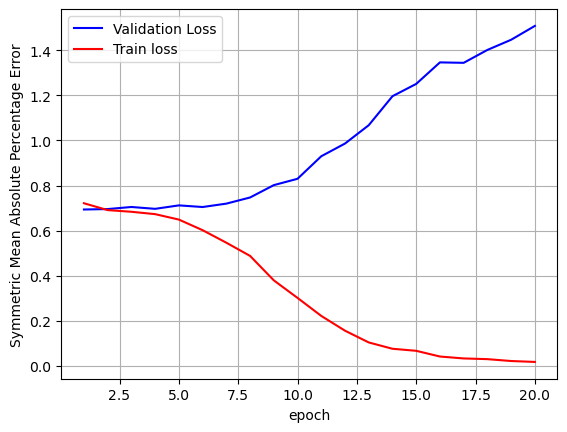

In [51]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(1,1)
ax.set_xlabel('epoch');ax.set_ylabel('Symmetric Mean Absolute Percentage Error')

x=list(range(1,20+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

training of lstm model 

In [52]:
lstm_model=Sequential()
lstm_model.add(LSTM(128,activation='relu',input_shape=(None,1)))
lstm_model.add(Dense(64,activation='relu'))
lstm_model.add(Flatten())
lstm_model.add(Dense(1,activation='linear'))

D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [53]:
lstm_model.compile(optimizer=Adam(),metrics=[k_smape],loss='mean_absolute_error')
lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,881 (292.50 KB)

 Trainable params: 74,881 (292.50 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
import tensorflow as tf

def smape(y_true, y_pred):
    """
    Symmetric Mean Absolute Percentage Error (SMAPE) calculation.
    """
    # Ensure both y_true and y_pred are of type float32
    y_true = tf.cast(y_true, dtype='float32')
    y_pred = tf.cast(y_pred, dtype='float32')
    
    epsilon = 1e-10  # To avoid division by zero
    denominator = (tf.abs(y_true) + tf.abs(y_pred)) / 2.0
    diff = tf.abs(y_true - y_pred) / tf.clip_by_value(denominator, epsilon, tf.float32.max)
    
    return 100 * tf.reduce_mean(diff)


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# 1. Generate some example data (replace this with your actual data)
num_samples = 1000
sequence_length = 200  # Example sequence length
num_features = 5  # Number of features per time step

# Random data (replace with actual dataset)
X = np.random.rand(num_samples, sequence_length, num_features)  # Input data
y = np.random.randint(0, 2, num_samples)  # Binary classification labels

# 2. Preprocess the data
# Split the dataset into train and validation sets
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Define the LSTM model
model = Sequential()

# Add LSTM layer
model.add(LSTM(128, activation='tanh', input_shape=(sequence_length, num_features), return_sequences=False))

# Add dropout to prevent overfitting (optional)
model.add(Dropout(0.5))

# Add fully connected layer
model.add(Dense(64, activation='relu'))

# Output layer for binary classification (sigmoid activation)
model.add(Dense(1, activation='sigmoid'))

# 4. Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 5. Train the model
history = model.fit(
    train_x, train_y,              # Training data and labels
    epochs=20,                     # Number of epochs
    batch_size=32,                 # Batch size
    validation_data=(val_x, val_y)  # Validation data
)

def smape(y_true, y_pred):
    """
    Symmetric Mean Absolute Percentage Error (SMAPE) calculation.
    """
    epsilon = 1e-10  # To avoid division by zero
    denominator = (tf.abs(y_true) + tf.abs(y_pred)) / 2.0
    diff = tf.abs(y_true - y_pred) / tf.clip_by_value(denominator, epsilon, tf.float32.max)
    return 100 * tf.reduce_mean(diff)

# 7. Evaluate the model using SMAPE
y_pred = model.predict(val_x)

# Calculate SMAPE between the true and predicted values
smape_value = smape(val_y, y_pred)
print(f"Symmetric Mean Absolute Percentage Error is: {smape_value.numpy():.4f}")


Epoch 1/20


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.5380 - loss: 0.6976 - val_accuracy: 0.5050 - val_loss: 0.7174
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.5230 - loss: 0.6954 - val_accuracy: 0.4800 - val_loss: 0.6942
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.5268 - loss: 0.6916 - val_accuracy: 0.5050 - val_loss: 0.6970
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.5174 - loss: 0.6955 - val_accuracy: 0.4900 - val_loss: 0.6957
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5372 - loss: 0.6898 - val_accuracy: 0.5050 - val_loss: 0.6971
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5304 - loss: 0.6915 - val_accuracy: 0.4900 - val_loss: 0.6965
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.5634 - loss: 0.6873 - val_accuracy: 0.5100 - val_loss: 0.6967
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5146 - loss: 0.6916 - val_accuracy: 0.5050 - val_loss: 0.

InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a int32 tensor but is a float tensor [Op:AddV2] name: 

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [7]:
train_1=pd.read_csv('train_1.csv',parse_dates=True)
key_1=pd.read_csv('key_1.csv')

In [57]:
train_1.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [8]:
train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [9]:
train_1.shape

(145063, 551)

In [10]:
train_1.isnull().sum()

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
              ...  
2016-12-27     3701
2016-12-28     3822
2016-12-29     3826
2016-12-30     3635
2016-12-31     3465
Length: 551, dtype: int64

In [11]:
train_1=train_1.replace(np.NAN,0)
train_1.isnull().sum().sum()

0

Text(0.5, 1.0, 'Web traffic original data')

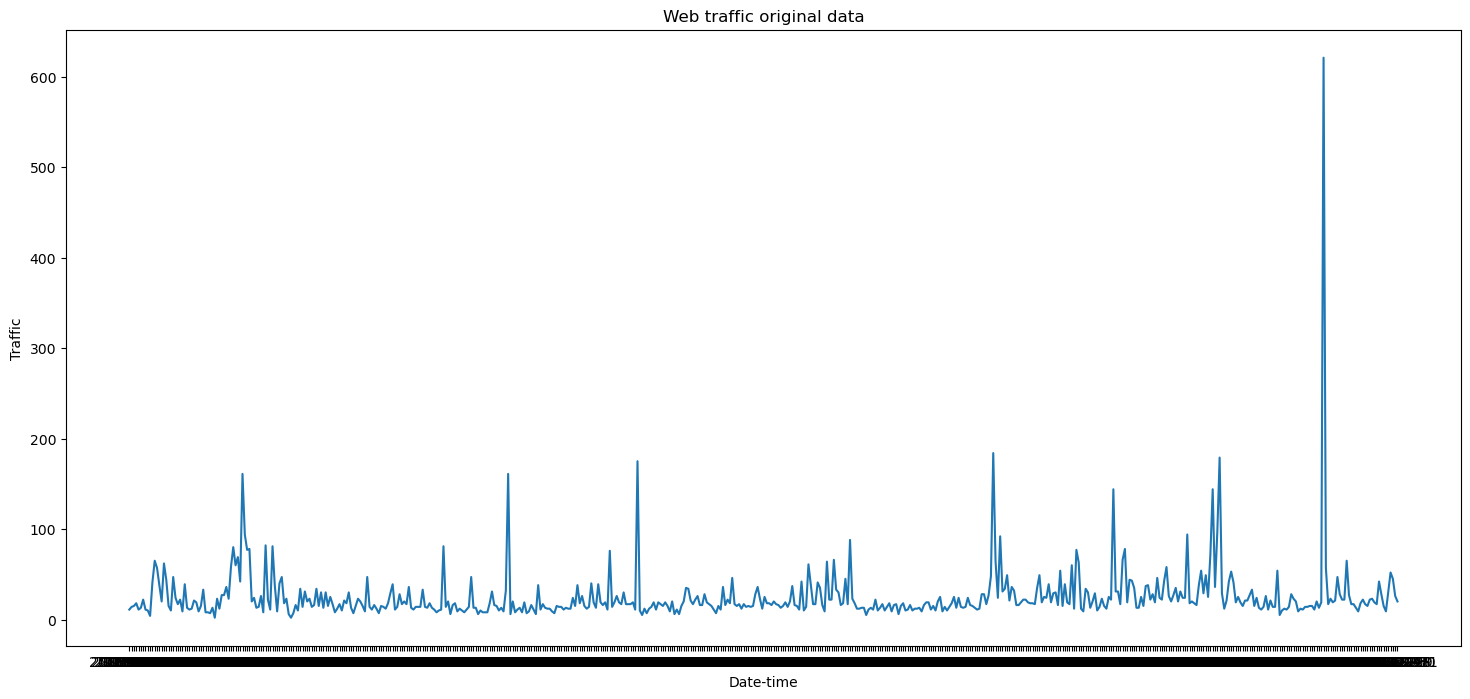

In [12]:
#plotting the random time series to get the idea of basic flow of data
rcParams['figure.figsize']=18,8
y=train_1.loc[1][1:]
plt.plot(y)
plt.xlabel('Date-time')
plt.ylabel('Traffic')
plt.title('Web traffic original data')

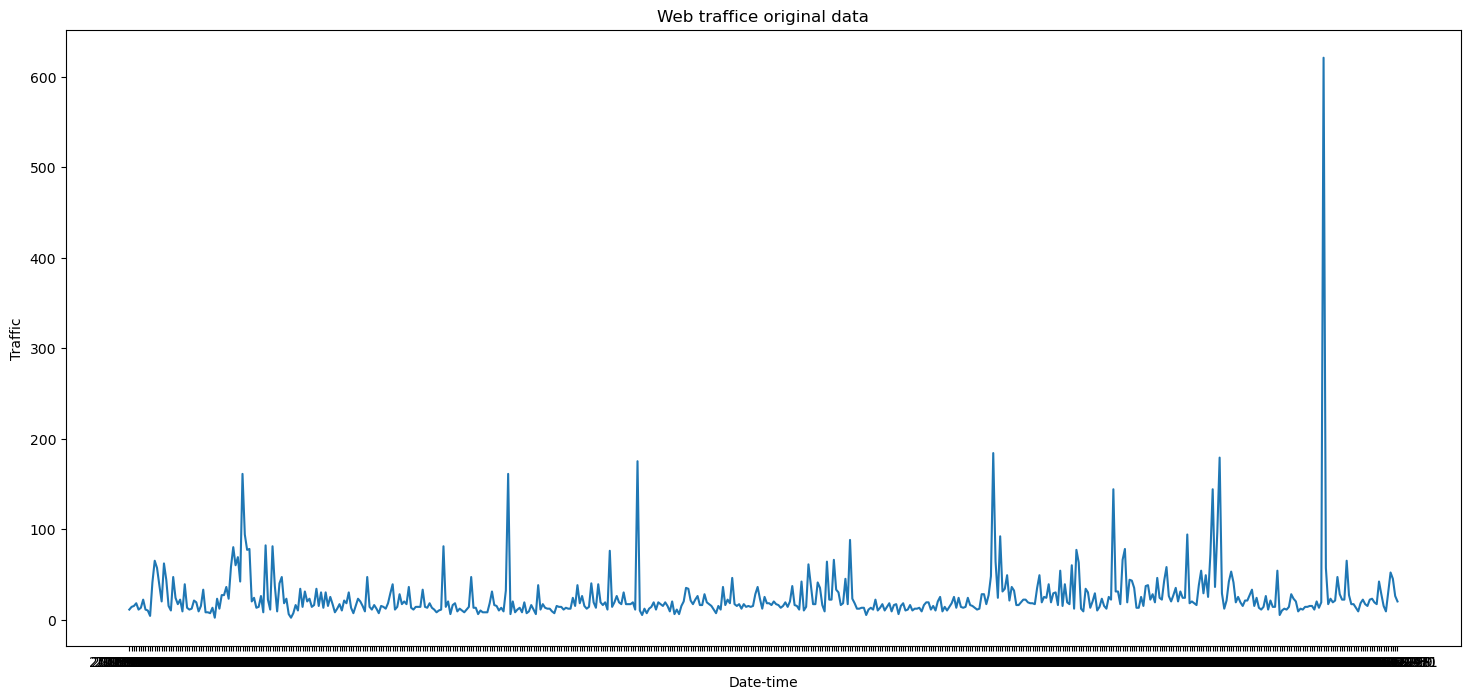

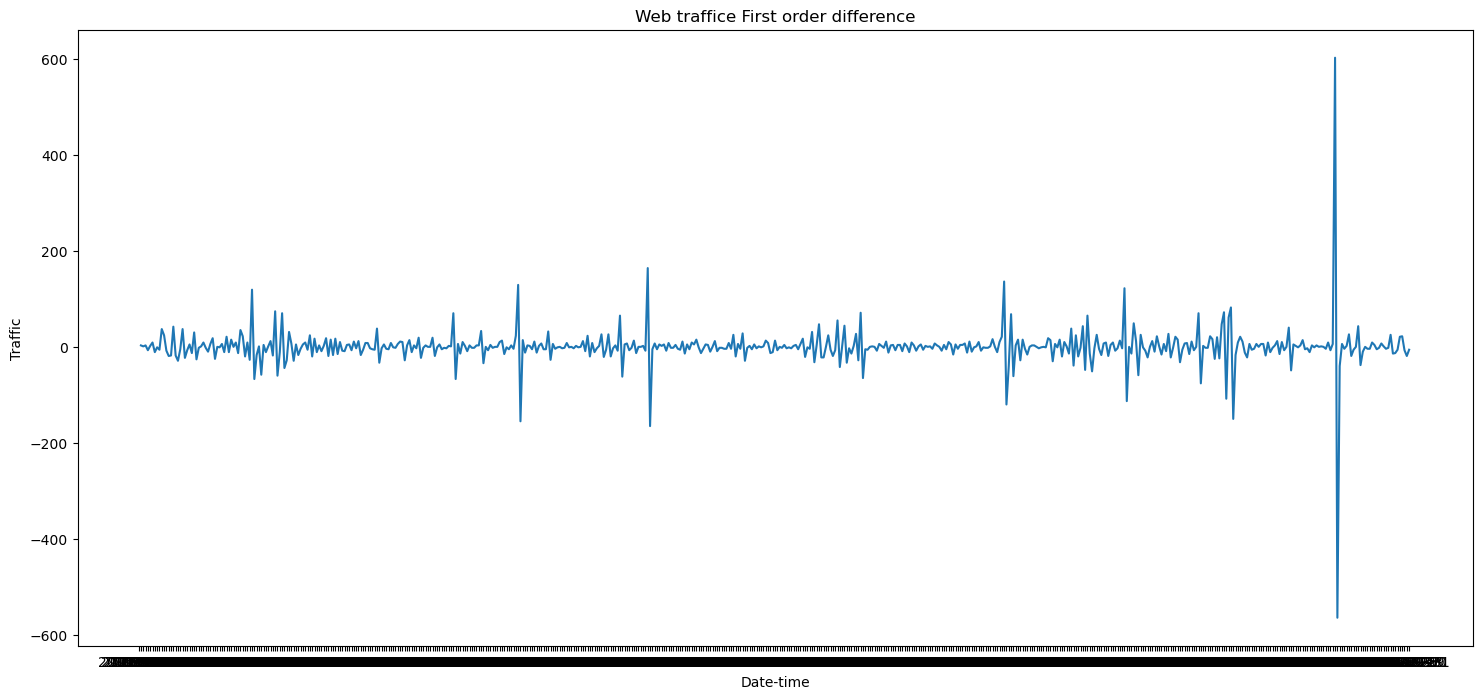

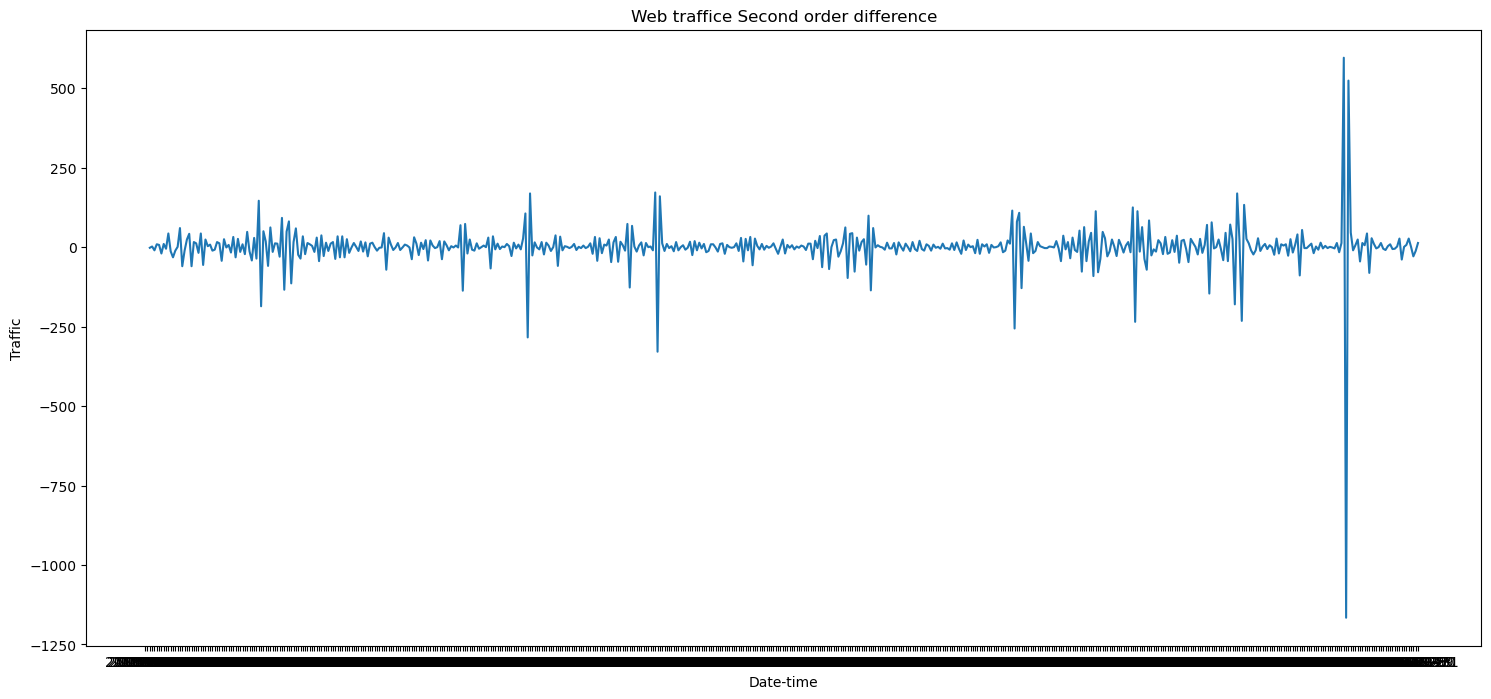

In [13]:
first_order=y.diff()
second_order=first_order.diff()

plt.plot(y)
plt.xlabel('Date-time',fontsize=10)
plt.ylabel('Traffic',fontsize=10)
plt.title('Web traffice original data')
plt.show()
#first order plot
plt.plot(first_order)
plt.xlabel('Date-time',fontsize=10)
plt.ylabel('Traffic',fontsize=10)
plt.title('Web traffice First order difference')
plt.show()
#2nd order plot
plt.plot(second_order)
plt.xlabel('Date-time',fontsize=10)
plt.ylabel('Traffic',fontsize=10)
plt.title('Web traffice Second order difference')
plt.show()

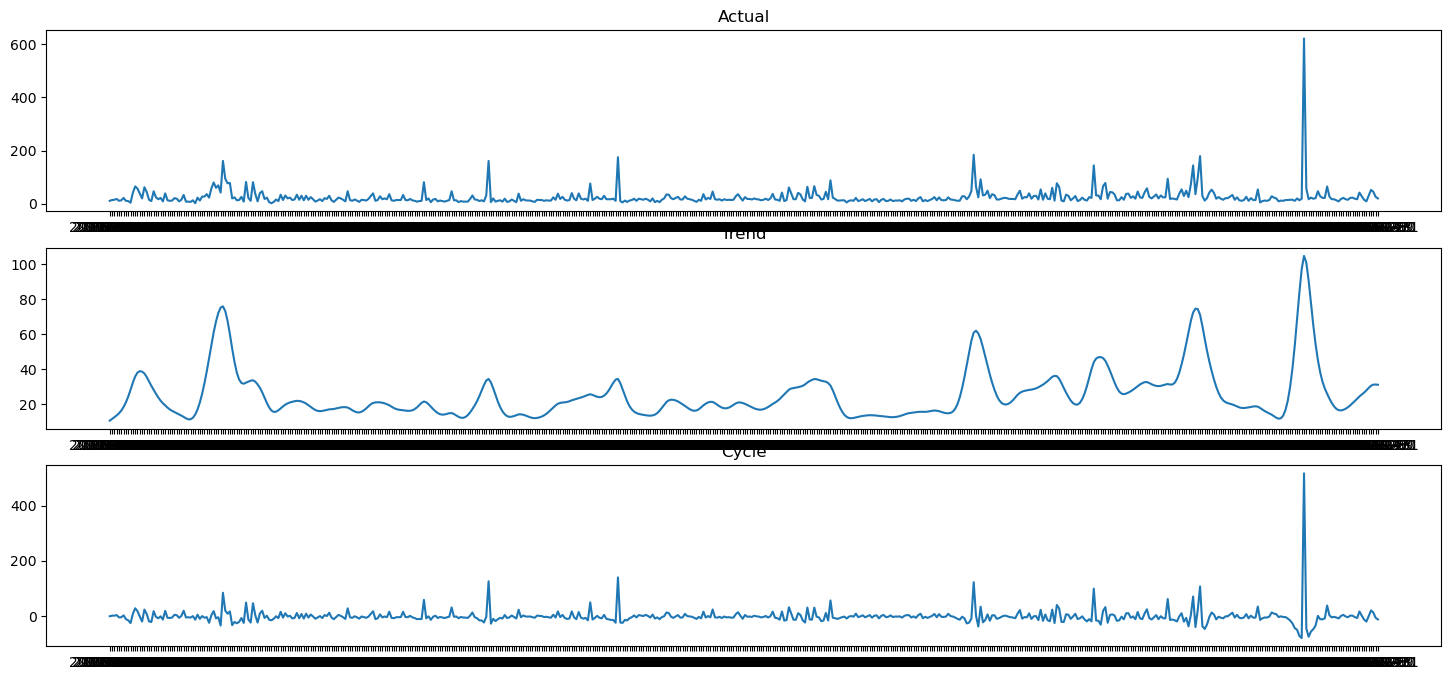

In [14]:
import statsmodels.api as sm
series=y
cycle,trend=sm.tsa.filters.hpfilter(series,50)  #time series decomposition
fig,ax=plt.subplots(3,1)
ax[0].plot(series)
ax[0].set_title('Actual')
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[2].plot(cycle)
ax[2].set_title('Cycle')
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_11708\961611802.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  arr.append(y[i])


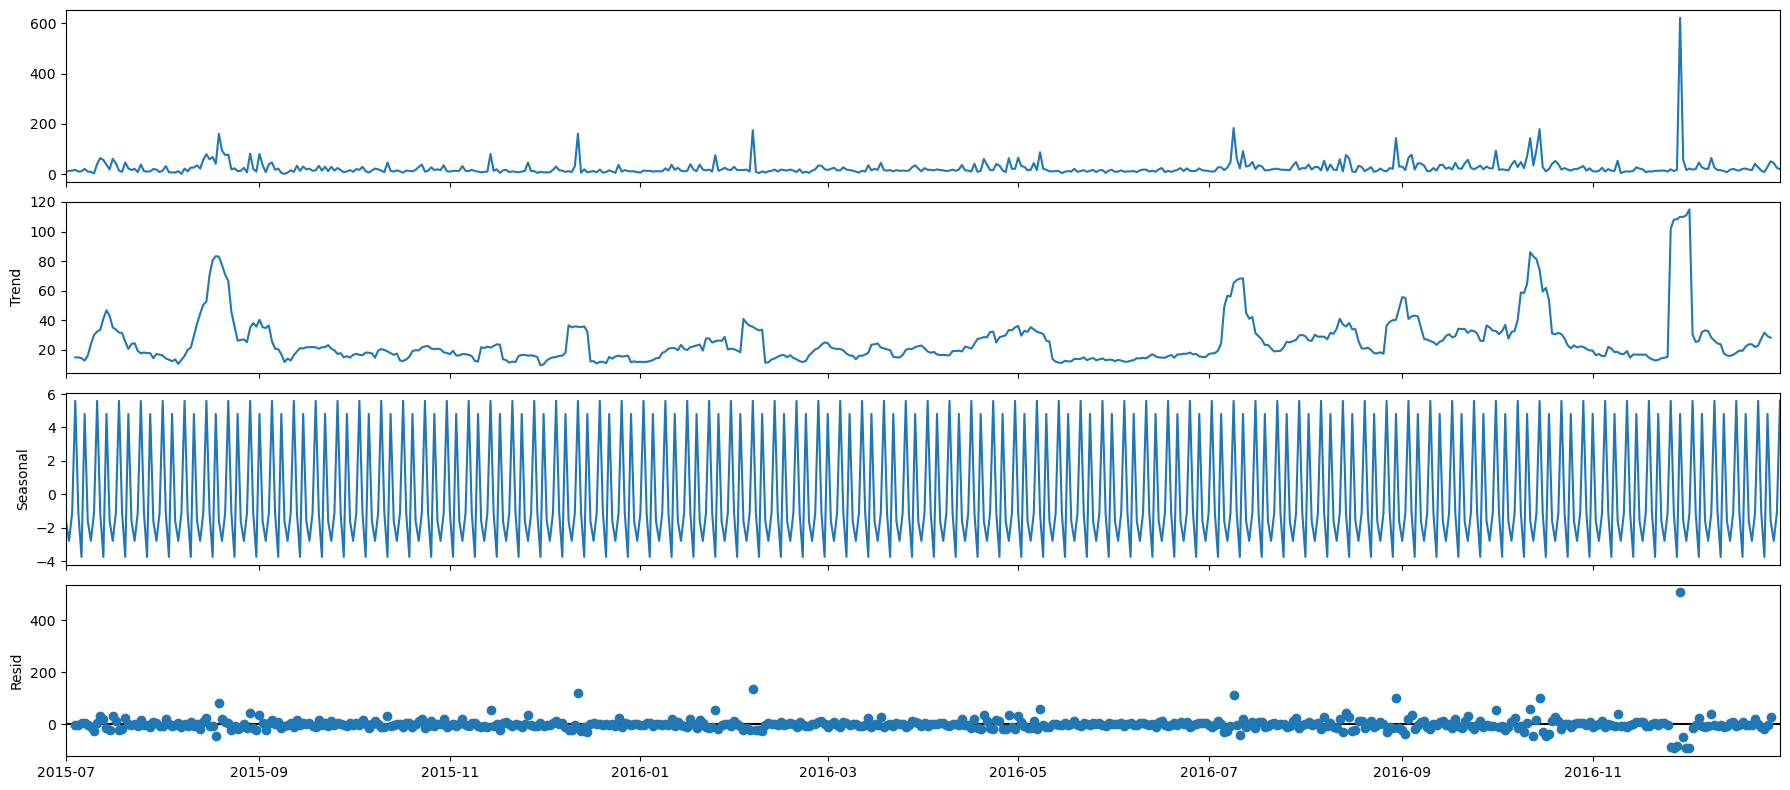

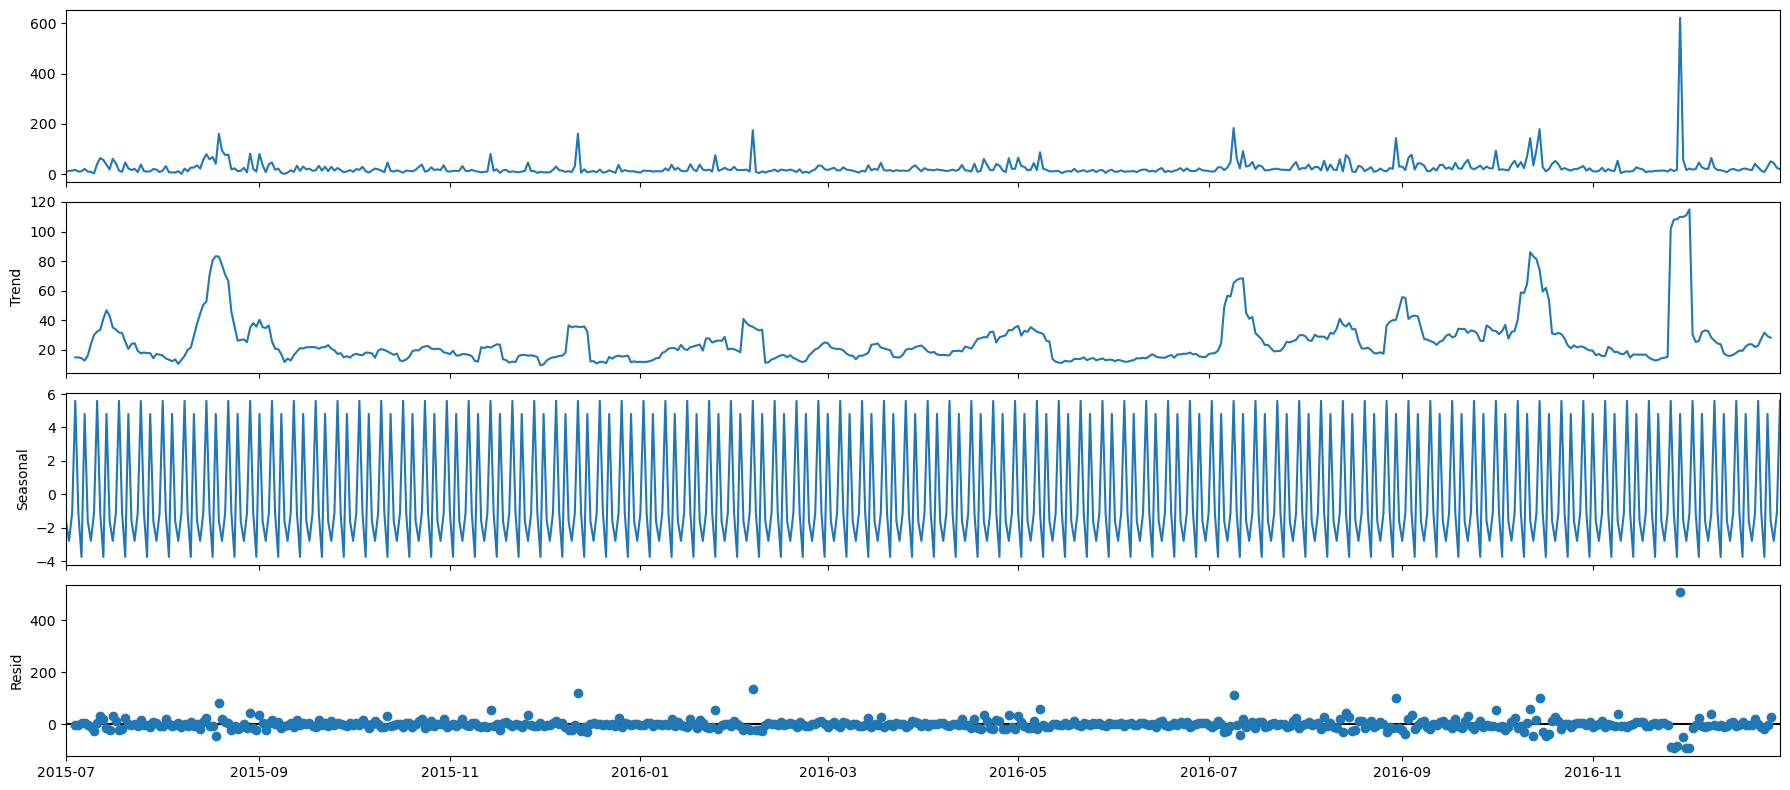

In [15]:

ind=pd.to_datetime(y.index)
arr=[]
for i in range(len(y)):
    arr.append(y[i])
arr=pd.DataFrame(arr)
arr.index=ind
decomposition=sm.tsa.seasonal_decompose(arr)
decomposition.plot()

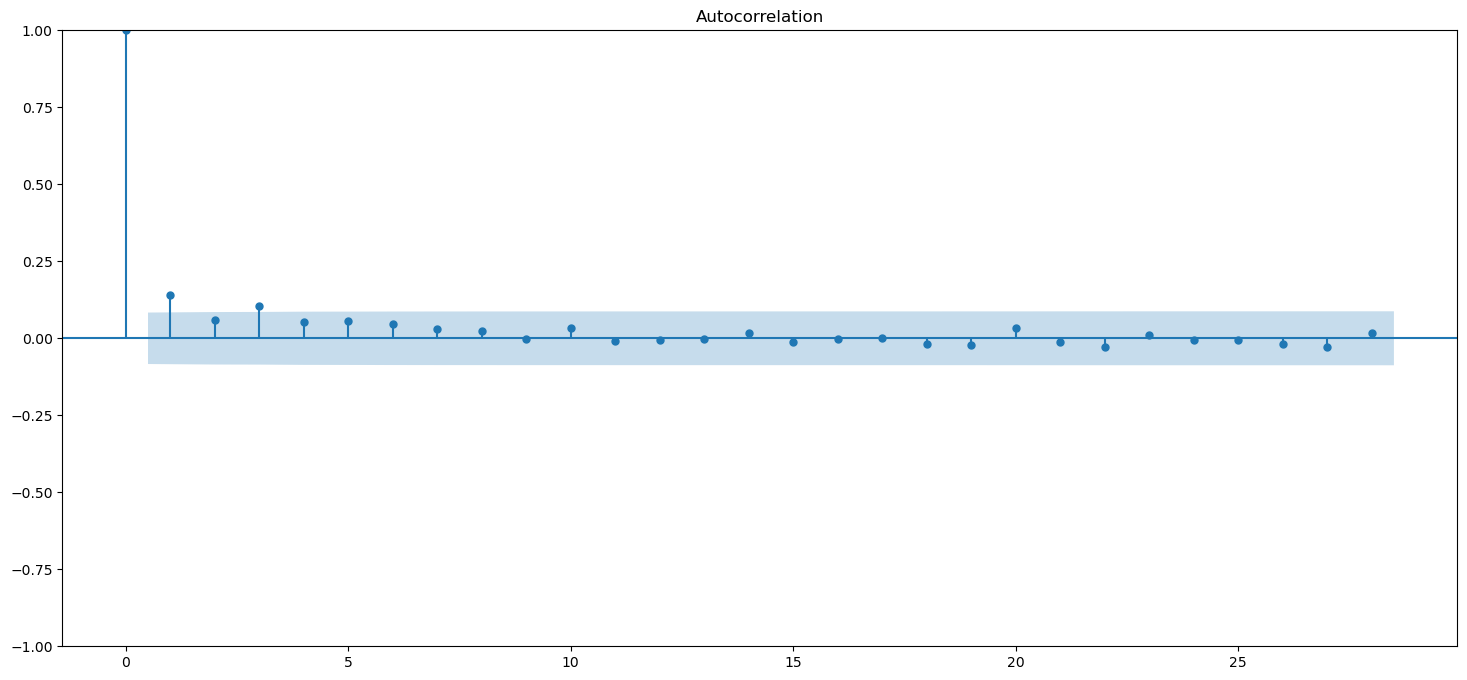

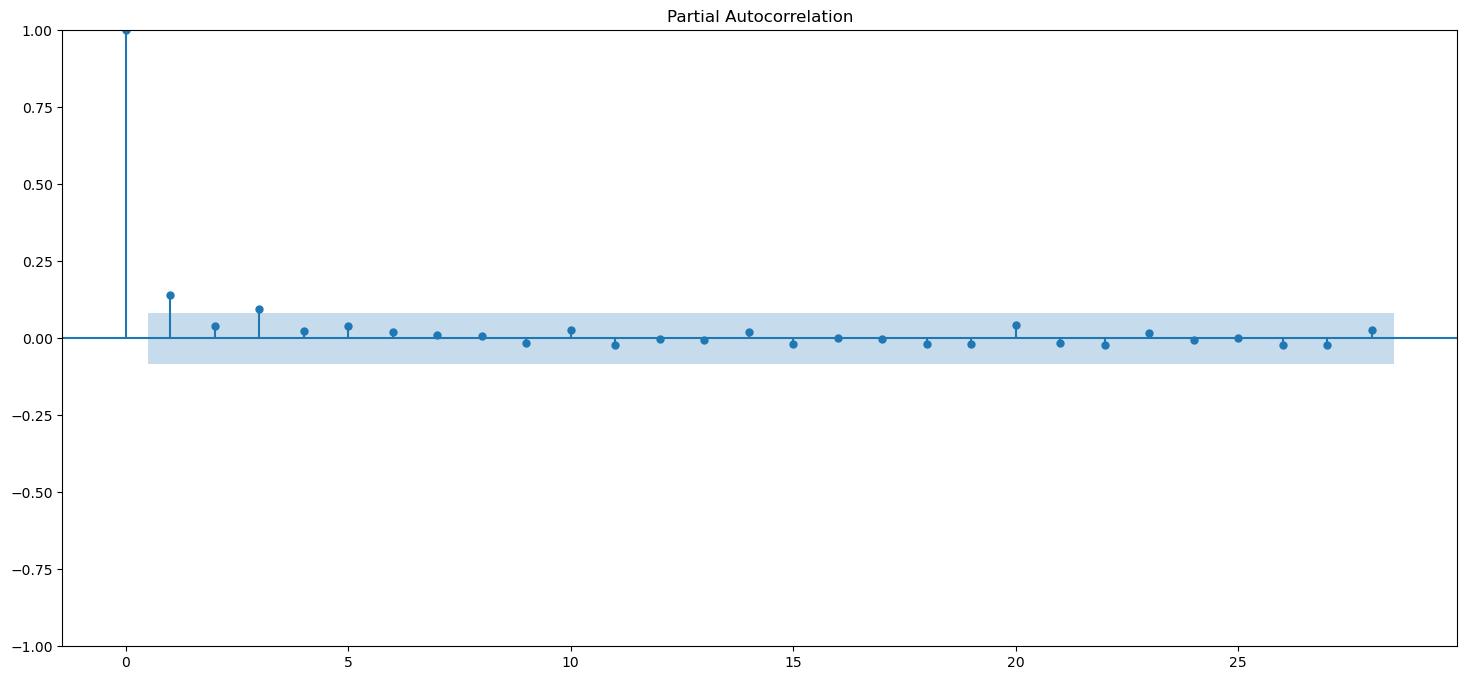

In [16]:
#ACF and PCAF plots
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
plot_acf(arr)
plot_pacf(arr)
acf_values=sm.tsa.stattools.acf(y)
pacf_values=sm.tsa.stattools.pacf(y)

In [17]:
import pandas as pd
train_1 = pd.read_csv('train_1.csv')


In [18]:
train_1[['topic','lang','access','type']]=train_1['Page'].str.extract(r'(?P<topic>.*)\_(?P<lang>.*).wikipedia.org\_(?P<access>.*)\_(?P<type>.*)')

In [19]:
train_1.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,topic,lang,access,type
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,14.0,20.0,22.0,19.0,18.0,20.0,2NE1,zh,all-access,spider
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,9.0,30.0,52.0,45.0,26.0,20.0,2PM,zh,all-access,spider
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,4.0,4.0,6.0,3.0,4.0,17.0,3C,zh,all-access,spider
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,16.0,11.0,17.0,19.0,10.0,11.0,4minute,zh,all-access,spider
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,11.0,27.0,13.0,36.0,10.0,52_Hz_I_Love_You,zh,all-access,spider


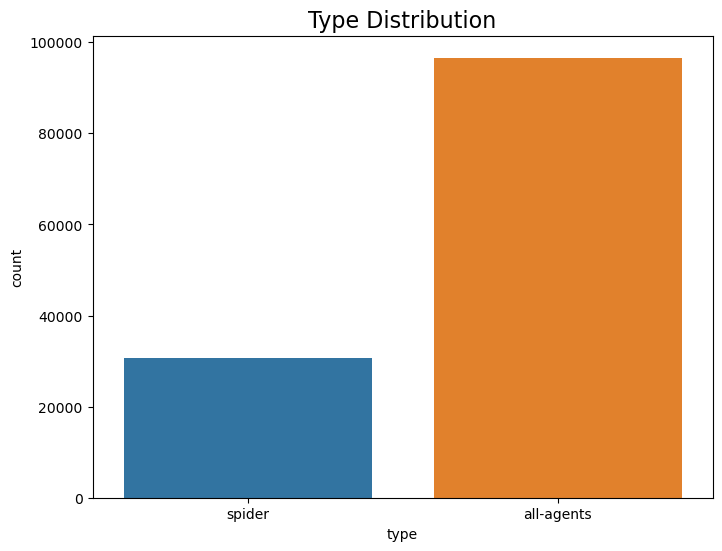

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_1' is a DataFrame and has a 'type' column with categorical data
plt.figure(figsize=(8, 6))  # Set figure size
plt.title('Type Distribution', fontsize=16)

# Use 'x' parameter to specify the 'type' column
sns.countplot(x='type', data=train_1)

# Show the plot
plt.show()


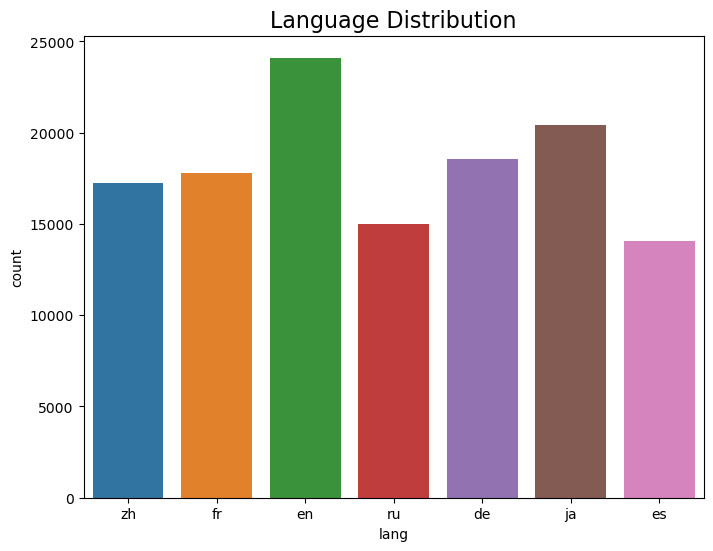

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_1' is a DataFrame and has a 'lang' column
plt.figure(figsize=(8, 6))  # Set figure size
plt.title('Language Distribution', fontsize=16)

# Use 'x' parameter to specify the 'lang' column
sns.countplot(x='lang', data=train_1)

# Show the plot
plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_11708\4150317672.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(language_df.loc[i], label=i)
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\hp\AppData\Local\Temp\ipykernel_11708\4150317672.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility)

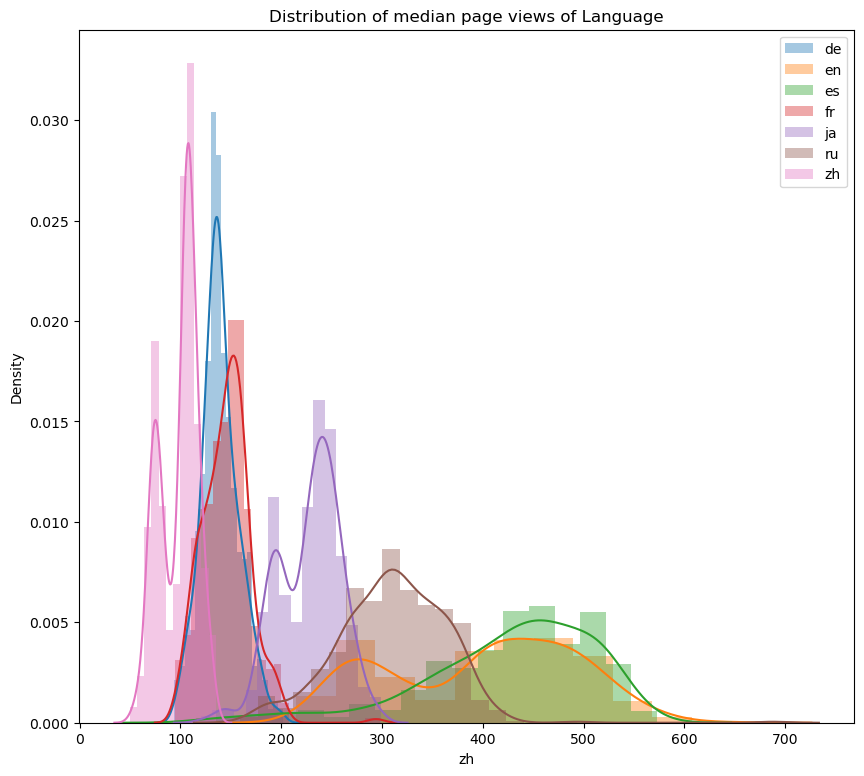

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'train_1' is the DataFrame

# Select only numeric columns and group by 'lang'
language_df = train_1.groupby('lang').median(numeric_only=True)
langs = language_df.index.values

plt.figure(figsize=(10, 9))
plt.title('Distribution of median page views of Language')

# Loop through each language and plot the distribution
for i in langs:
    sns.distplot(language_df.loc[i], label=i)

plt.legend()
plt.show()


<Axes: >

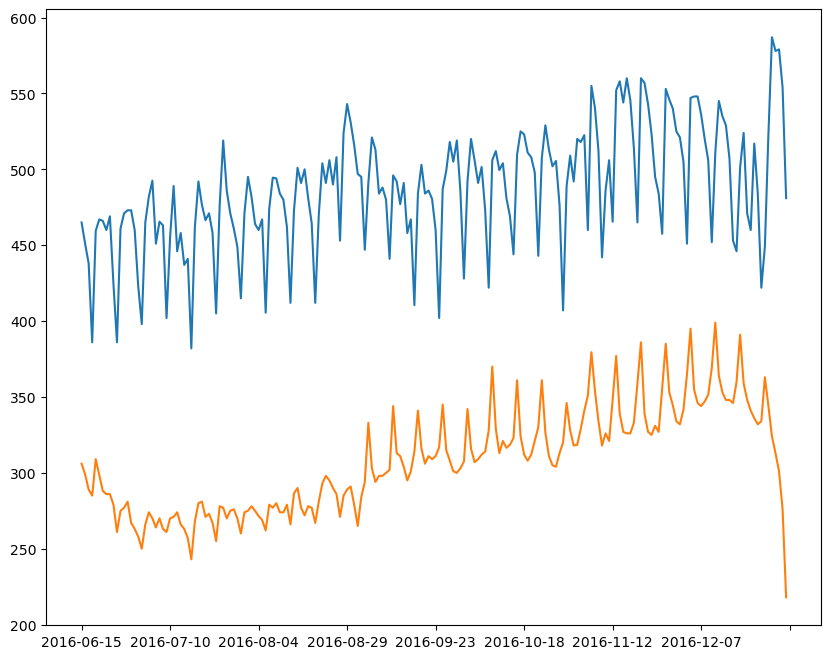

In [24]:
plt.figure(figsize=(10,8))
language_df.xs('en')[350:550].plot()
language_df.xs('ru')[350:550].plot()

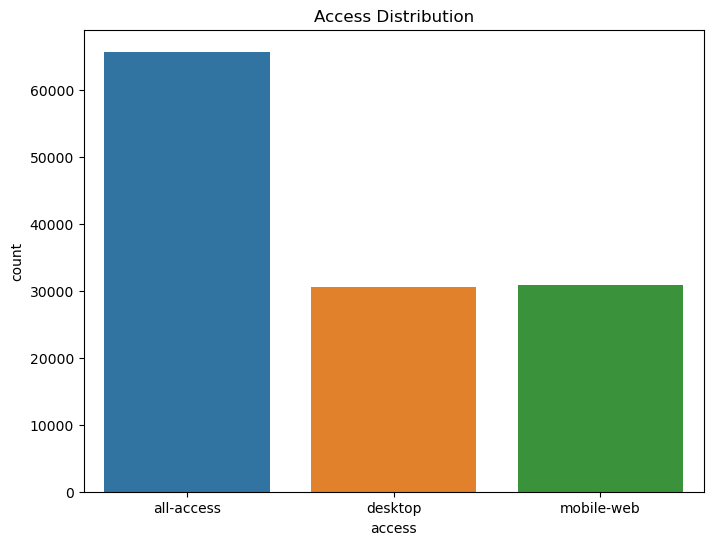

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
plt.title("Access Distribution")
sns.countplot(x="access", data=train_1)  
plt.show()


In [27]:
import numpy as np
import pickle
from keras.models import model_from_json
import pandas as pd
import datetime
import re
import warnings
warnings.filterwarnings('ignore')
class final:
    def load_files(self):
        
        json_file = open('model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.model = model_from_json(loaded_model_json)
        self.model.load_weights("model.h5")

        with open('access_enc.pkl','rb') as file:
            self.access_enc=pickle.load(file)

        with open('lang_enc.pkl','rb') as file:
            self.lang_enc=pickle.load(file)

        with open('spider_enc.pkl','rb') as file:
            self.agent_enc=pickle.load(file)
        self.new_data=pd.read_csv('final_data.csv')    
    def find_access(self,page):
        k=max([i.start() for i in re.finditer('org_',page)])   
        if('all-access' in page[k:]):
            access='all_access'
        if('desktop' in page[k:]):
            access='desktop'
        if('mobile' in page[k:]): 
            access='mobile'
        k=access    
        access=self.access_enc.transform([access]).reshape(1,1)    
        return access,k 
    def find_lang(self,page):
        index=page.find('.wikipedia')
        lang=page[index-1:index-3:-1][::-1]
        lang_dict={'de':'German','en':'English', 'es':'Spanish', 'fr':'French', 'ja':'Japanese', 'nt':'Media', 'ru':'Russian', 'zh':'Chinese'}
        language=lang_dict[lang]
        lang=self.lang_enc.transform([lang]).reshape(1,1)
        return lang,language
    def find_agent(self,page):
        if('spider' in page):
            spider='spider'
        else:
            spider='non-spider' 
        k=spider  
        agent=self.agent_enc.transform([spider]).reshape(1,1)
        return agent,k
    def find_data(self,ind,date):
        data=self.new_data.iloc[ind].values
        date1=datetime.date(2015,7,6)
        k=date.split('-')
        date2=datetime.date(int(k[0]),int(k[1]),int(k[2]))
        dif=(date2-date1).days
        data=np.log1p(data[dif+1:dif+6].astype(int))
        data=np.array(data).reshape(1,5,1)
        return data     
    def predict(self,ind,date):
        self.load_files()
        start=datetime.datetime.now()
        self.page=self.new_data['Page'].values[int(ind)]
        access,access1=self.find_access(self.page)
        lang,language=self.find_lang(self.page)
        agent,agent1=self.find_agent(self.page)
        data=self.find_data(int(ind),date)
        time=datetime.datetime.now()-start
        predicted=int(np.round(np.expm1(self.model.predict([data,access,lang,agent])[0])[0]))
        return(access1,agent1,language,predicted,time,self.page)

In [28]:
# Select only numeric columns from train_1
numeric_cols = train_1.select_dtypes(include='number')

# Group by 'lang' and 'access', and calculate median for numeric columns
access_lang_df = train_1.groupby(['lang', 'access'])[numeric_cols.columns].median().reset_index()
# Display the result
print(access_lang_df)


   lang      access  2015-07-01  2015-07-02  2015-07-03  2015-07-04  \
0    de  all-access        24.0        25.0        22.0        23.0   
1    de     desktop       211.0       202.5       179.0       151.0   
2    de  mobile-web       129.0       130.0       140.0       166.0   
3    en  all-access        53.0        46.0        41.0        41.0   
4    en     desktop       955.5       930.0       824.0       761.0   
5    en  mobile-web      1103.0      1102.5      1163.0      1317.0   
6    es  all-access        53.0        50.0        41.0        39.0   
7    es     desktop       736.0       731.0       599.0       402.0   
8    es  mobile-web       487.0       467.0       432.0       364.0   
9    fr  all-access        28.0        23.0        23.0        23.0   
10   fr     desktop       205.0       205.0       193.0       166.0   
11   fr  mobile-web       118.0       121.0       122.0       134.0   
12   ja  all-access        25.0        20.0        21.0        23.0   
13   j

Index(['lang', 'access', '2015-07-01', '2015-07-02', '2015-07-03',
       '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=552)


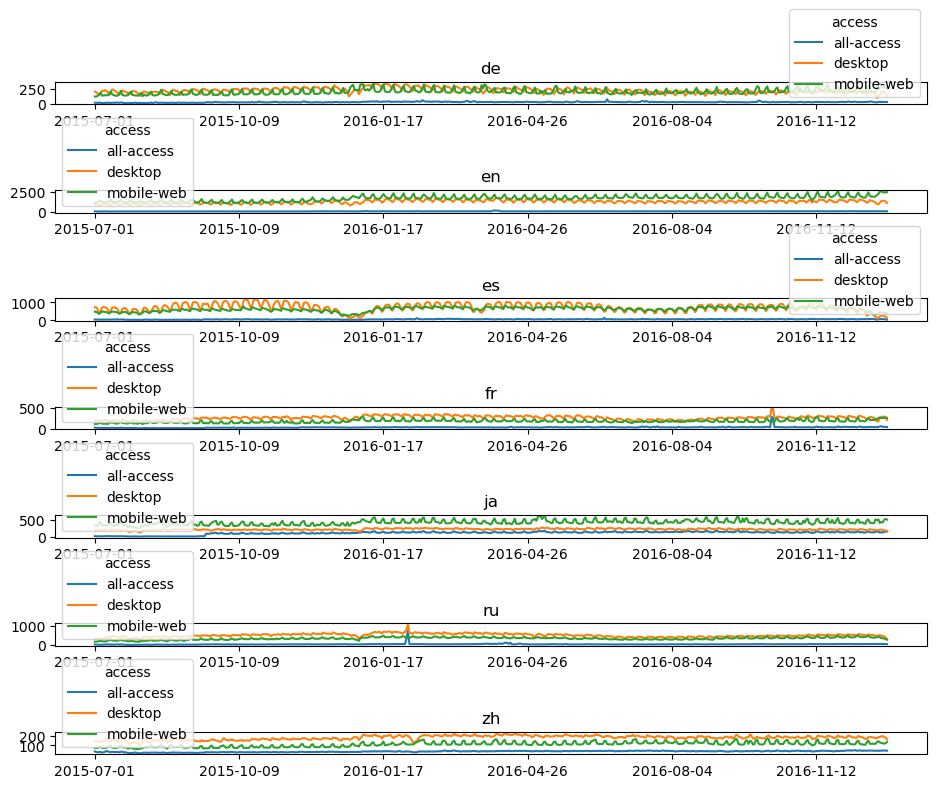

In [29]:
print(access_lang_df.columns)
access_lang_df.set_index(['lang', 'access'], inplace=True)
fig, a = plt.subplots(len(langs), 1, figsize=(10, 8))
for i, j in enumerate(langs):
    ax = a[i]
    access_lang_df.xs(j, level='lang').T.plot(ax=ax)
    ax.set_title(j)
fig.tight_layout(pad=3.0)
plt.show()

In [30]:
topic_count=train_1['topic'].value_counts()

In [31]:
melt_df=pd.melt(train_1.iloc[:,0:550],'Page',var_name='Date')

In [32]:
melt_df['Date']=pd.to_datetime(melt_df['Date'])
melt_df['Day']=melt_df['Date'].dt.weekday
melt_df['week']=melt_df['Date'].dt.isocalendar().week

In [33]:
melt_df['Day'].replace(0,'Sunday',inplace=True)
melt_df['Day'].replace(1,'Monday',inplace=True)
melt_df['Day'].replace(2,'Tuesday',inplace=True)
melt_df['Day'].replace(3,'Wednesday',inplace=True)
melt_df['Day'].replace(4,'Thursday',inplace=True)
melt_df['Day'].replace(5,'Friday',inplace=True)
melt_df['Day'].replace(6,'Saturday',inplace=True)

In [34]:
views_day=melt_df.groupby('Day')['value'].sum()

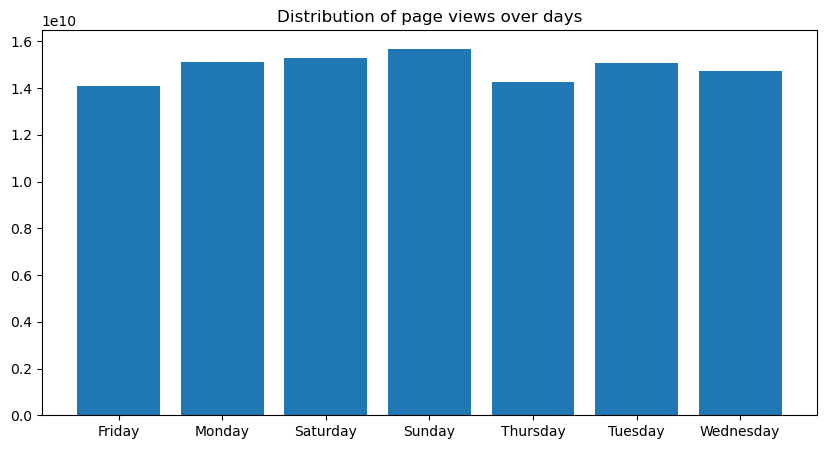

In [35]:
plt.figure(figsize=(10,5))
plt.title('Distribution of page views over days')
plt.bar(views_day.index,views_day.values)
plt.show()